Apollo Hospitals is acclaimed for pioneering the private healthcare revolution in the country. We need to find insights from data and help hospital to be more efficient in diagnostic, treatment and map the spread of pandemic.
<br>

We have insurance costed per person data of Delhi divided into 4 regions for differnt age, type of people.
<br>
<br>



The company wants to know:

• Which variables are significant in predicting the reason for hospitalization for different regions

• How well some variables like viral load, smoking, Severity Level describe the hospitalization charges

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import itertools
import math
import statsmodels.api as sm

In [6]:
!pip uninstall scipy

Found existing installation: scipy 1.4.1
Uninstalling scipy-1.4.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scipy-1.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scipy/*
Proceed (y/n)? y
  Successfully uninstalled scipy-1.4.1


In [7]:
!pip install scipy==1.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.5 MB 83.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
from scipy import stats
from scipy.stats import anderson, shapiro
import scipy 
scipy.__version__

'1.7.0'

In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Scaler Case Studies/6.ApolloHospitals/data.csv')

print(df.columns, '\n\n')
print('Number of rows in our dataset: ', df.shape[0], '  Number of columns in our dataset: ', df.shape[0], '\n\n',)
display(df.head())

Index(['Unnamed: 0', 'age', 'sex', 'smoker', 'region', 'viral load',
       'severity level', 'hospitalization charges'],
      dtype='object') 


Number of rows in our dataset:  1338   Number of columns in our dataset:  1338 




,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


# Usual data exploration

we see that age, severity level, hospitalization charges  are of integer type -- sex, smoker, region are of string / object type  --  viral load is float.
<br>

From describe we found that hospitalization charges is right skewed.

In [5]:
# Dropping column Unnamed: 0, as it is just a row count column, not needed for further analysis
df.drop(columns=['Unnamed: 0'], inplace=True)

# Every variable seems to be by default integer or float
display(df.dtypes)

display(df.describe())

age                          int64
sex                         object
smoker                      object
region                      object
viral load                 float64
severity level               int64
hospitalization charges      int64
dtype: object

,age,viral load,severity level,hospitalization charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,1.094918,33176.058296
std,14.049960,2.032796,1.205493,30275.029296
min,18.000000,5.320000,0.000000,2805.000000
25%,27.000000,8.762500,0.000000,11851.000000
50%,39.000000,10.130000,1.000000,23455.000000
75%,51.000000,11.567500,2.000000,41599.500000
max,64.000000,17.710000,5.000000,159426.000000


<br>
<br>

We see that there are no values missing

In [6]:
df.isnull().sum()

age                        0
sex                        0
smoker                     0
region                     0
viral load                 0
severity level             0
hospitalization charges    0
dtype: int64


***Feature Engineering & categorical to numerical***

In [7]:
df['age_bin'] = np.where(df['age']<=30, '20s',
                   np.where(df['age']<=40, '30s',
                   np.where(df['age']<=50, '40s', 
                   np.where(df['age']<=60, '50s', '60s'))))

# converting categorical to numerical
df['sex_label'] = np.where(df['sex']=='male', 1, 0)
df['smoker_label'] = np.where(df['smoker']=='yes', 1, 0)
df['region_label'] = np.where(df['region']=='northeast', 1,
                              np.where(df['region']=='southwest', 2,
                              np.where(df['region']=='northwest', 3, 0)))

<br>
<br>

separating out numerical and categorical columns into 2 different lists.

we will take severity level as categorical as it has only 6 distinct values.

In [8]:
categorical_cols = ['sex', 'smoker', 'region', 'severity level', 'age_bin']
numerical_cols = ['age', 'hospitalization charges', 'viral load', 'sex_label', 'smoker_label', 'region_label']

<br>
<br>

checking for unique values in categorical features.
<br>

• We see that we have almost equal number of male and female policy holders.

• Non somkers are way higher than no of smokers.

• Each region of Delhi has almost the same no. of beneficiaries except for south region where the count is bit higher.

• Most of the people are not severe. Also the count of people goes down as the severity level goes up.

• Most people insured are in the range 18 to 30

In [9]:
for col in categorical_cols:
    display(df[col].value_counts().sort_values()) 
    print()

female    662
male      676
Name: sex, dtype: int64

yes     274
no     1064
Name: smoker, dtype: int64

northeast    324
southwest    325
northwest    325
southeast    364
Name: region, dtype: int64

5     18
4     25
3    157
2    240
1    324
0    574
Name: severity level, dtype: int64

60s     91
30s    257
50s    265
40s    281
20s    444
Name: age_bin, dtype: int64

# Univariate Analysis

### Continuous univariate analysis and Outlier detection

Utility function for normality check

In [96]:
# Shapiro-Wilk Test
def shapiroWilk_test(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')


# Anderson-Darling Test
def andersonDarling_test(data):
    result = anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

**1) AGE**
<br>

From the output it is clear that age is not skewed.

we can see that more people belong to 18 and 19 and 64.

Also it is not normally distributed can be seen from QQ plot, ShpiroWilk test and AndersonDarling test.

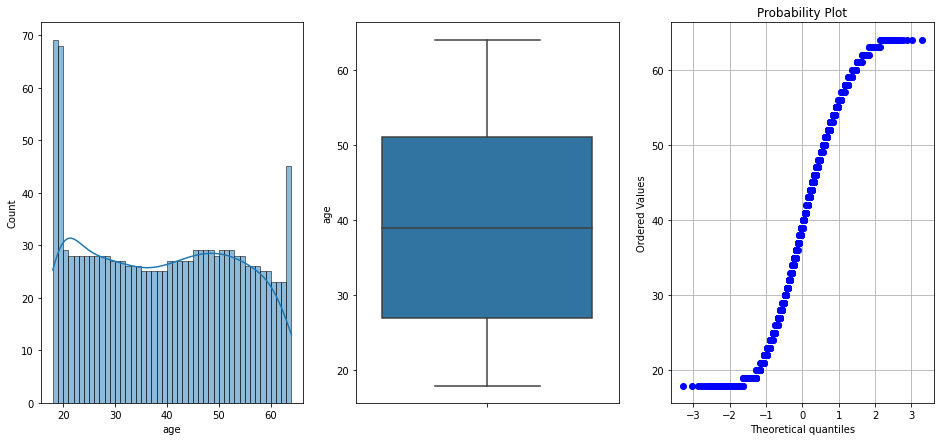




Statistics=0.945, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 3.136
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.777, data does not look normal (reject H0)
2.500: 0.906, data does not look normal (reject H0)
1.000: 1.078, data does not look normal (reject H0)


In [97]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['age'], bins=46, kde=True, ax=ax[0])
sns.boxplot(y=df['age'], ax=ax[1])

# qqplot
stats.probplot(df['age'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

print('\n\n')
shapiroWilk_test(df['age'])
andersonDarling_test(df['age'].sample(n=300))

**2) HOSPITALIZATION CHARGES**

Data is right skewed clearly. So we will use log transform to convert data into normal form. 

We can see below after log transform the data is normal distributed in QQ plot, still there are some extreme points at the right and left tail, we will handle them while doing statistical analysis.

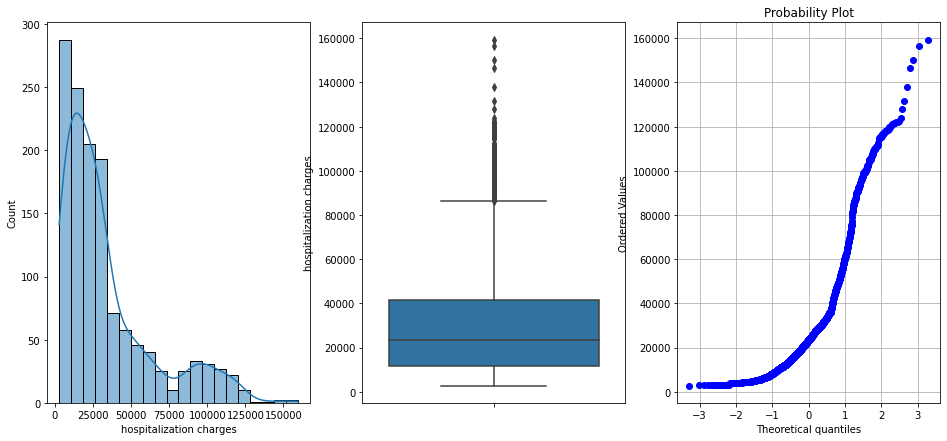




Statistics=0.815, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 18.400
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.777, data does not look normal (reject H0)
2.500: 0.906, data does not look normal (reject H0)
1.000: 1.078, data does not look normal (reject H0)


In [98]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['hospitalization charges'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['hospitalization charges'], ax=ax[1])

# qqplot
stats.probplot(df['hospitalization charges'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

print('\n\n')
shapiroWilk_test(df['hospitalization charges'])
andersonDarling_test(df['hospitalization charges'].sample(n=300))

In [99]:
df['hospitalization charges_log'] = np.log(df['hospitalization charges'])

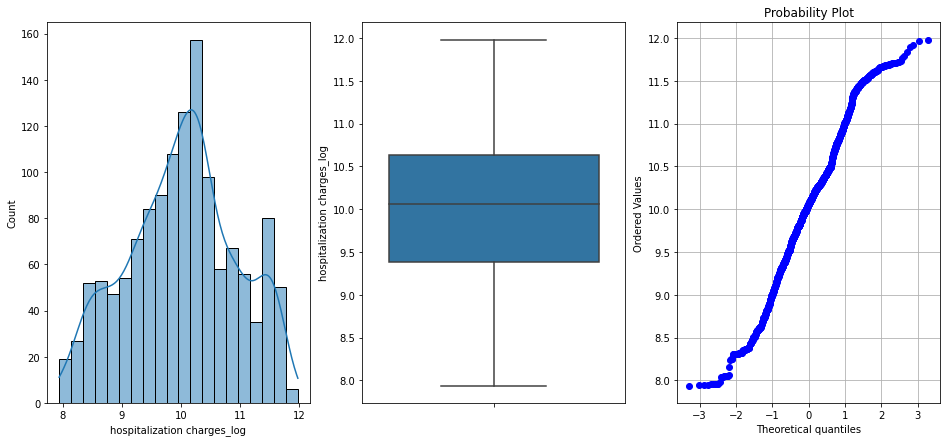




Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 1.323
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.777, data does not look normal (reject H0)
2.500: 0.906, data does not look normal (reject H0)
1.000: 1.078, data does not look normal (reject H0)


In [100]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['hospitalization charges_log'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['hospitalization charges_log'], ax=ax[1])

# qqplot
stats.probplot(df['hospitalization charges_log'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

print('\n\n')
shapiroWilk_test(df['hospitalization charges_log'])
andersonDarling_test(df['hospitalization charges_log'].sample(n=300))

**3) VIRAL LOAD**

Some points are right skewed. So we will try to handle them during statistical analysis.

ShpiroWilk test and AndersonDarling test are failing but QQ plot shows that data is almost normally distributed. However there are few outliers still present we will handle them while doing statistical analysis.

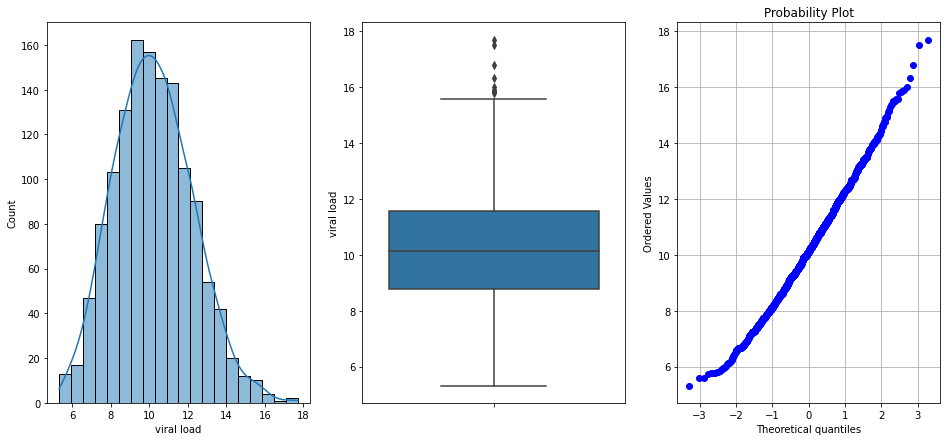




Statistics=0.994, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 0.422
15.000: 0.555, data looks normal (fail to reject H0)
10.000: 0.632, data looks normal (fail to reject H0)
5.000: 0.759, data looks normal (fail to reject H0)
2.500: 0.885, data looks normal (fail to reject H0)
1.000: 1.053, data looks normal (fail to reject H0)


In [101]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['viral load'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['viral load'], ax=ax[1])

# qqplot
stats.probplot(df['viral load'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

print('\n\n')
shapiroWilk_test(df['viral load'])
andersonDarling_test(df['viral load'].sample(n=100))

### Categorical univariate analysis 

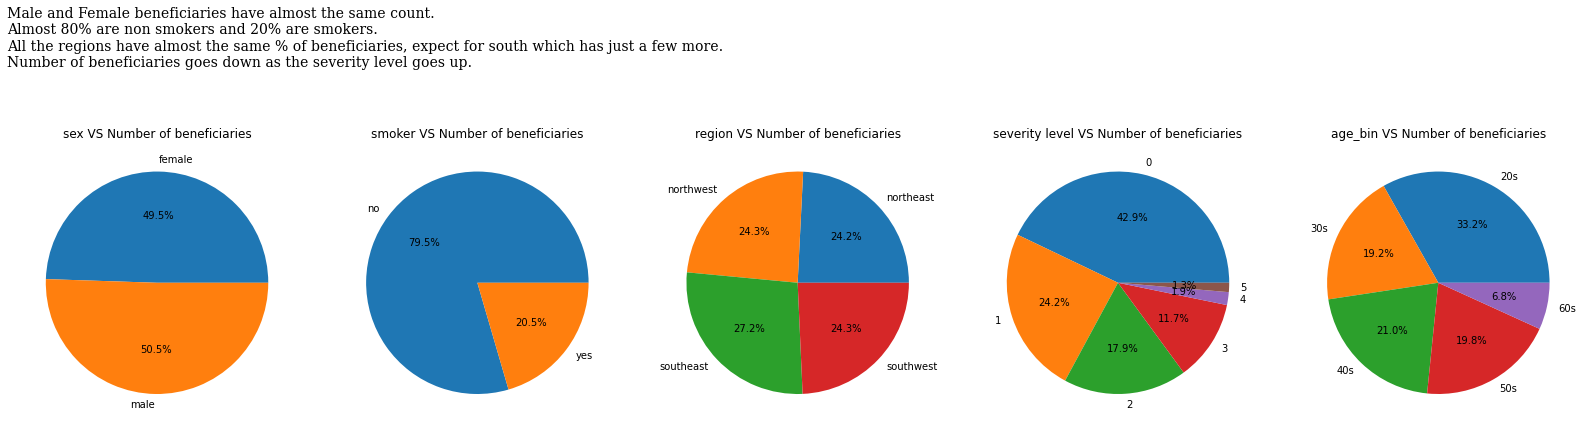

In [107]:
fig, ax = plt.subplots(1,5, figsize=(22,6))

for i, col in enumerate(categorical_cols):
    new_df = df[[col]].reset_index().groupby(col)['index'].count().reset_index()
    ax[i%5].pie(new_df['index'], labels=new_df[col], autopct='%.1f%%')
    ax[i%5].set_title(col + ' VS Number of beneficiaries')


observation = '''Male and Female beneficiaries have almost the same count.
Almost 80% are non smokers and 20% are smokers.
All the regions have almost the same % of beneficiaries, expect for south which has just a few more.
Number of beneficiaries goes down as the severity level goes up.'''
fig.text(0, 1, observation, fontsize=14, fontweight='light', fontfamily='serif')
plt.tight_layout()
plt.show()

# Bivariate Analysis

### Categorical VS Continuous



**SMOKER $\;\;$ VS $\;\;$ HOSPITALIZATION CHARGES**

Observation:

We can see that medical cost billed to health insurance are way higher for smokers than non smokers. As it should be.


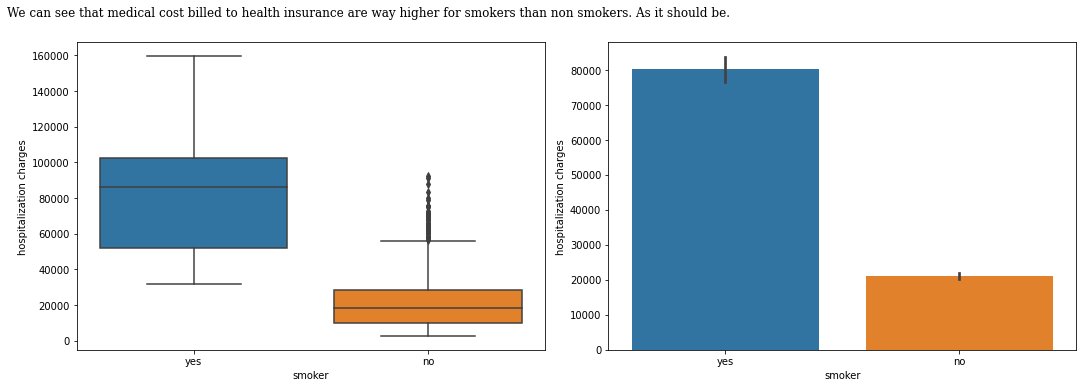

In [108]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, col in enumerate(['hospitalization charges']):
    sns.boxplot(data=df, y=col, x='smoker', ax=ax[0])
    sns.barplot(data=df, y=col, x='smoker', ax=ax[1])


observation = '''We can see that medical cost billed to health insurance are way higher for smokers than non smokers. As it should be.
'''
fig.text(0, 1, observation, fontsize=12, fontweight='light', fontfamily='serif')
plt.tight_layout()
plt.show()

**REGION $\;\;\;$ VS $\;\;\;$ HOSPITALIZATION CHARGES $\;$ & $\;$ VIRAL LOAD**
<br>

Observatons: 

By checking simple means we see that SouthEast region has the highest hospitalization charges, but it could be due to lot of outliers. Which will again check in the statistical analysis section.

Also we see that SouthEast region people has the highest amount of virus in their blood.

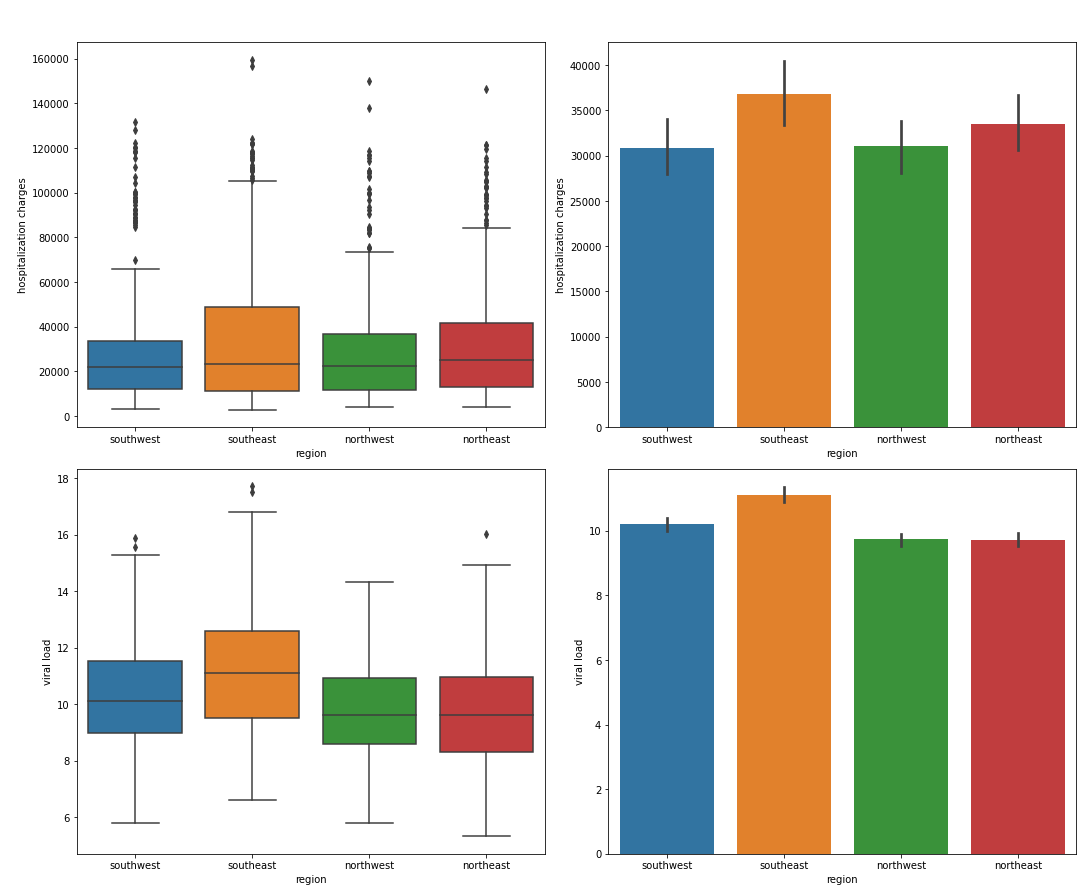

In [109]:
fig, ax = plt.subplots(2,2, figsize=(15,12))

for i, col in enumerate(['hospitalization charges', 'viral load']):
    sns.boxplot(data=df, y=col, x='region', ax=ax[i][0])
    sns.barplot(data=df, y=col, x='region', ax=ax[i][1])


observation = '''
'''
fig.text(0, 1, observation, fontsize=12, fontweight='light', fontfamily='serif')
plt.tight_layout()
plt.show()

**Security Level $\;\;\;$ VS $\;\;\;$ HOSPITALIZATION CHARGES**

Observation:

Security Level (severe the patient is) seems counter intuitive as the mean is increasing till level 3 then decreasing as the severity incrases. 

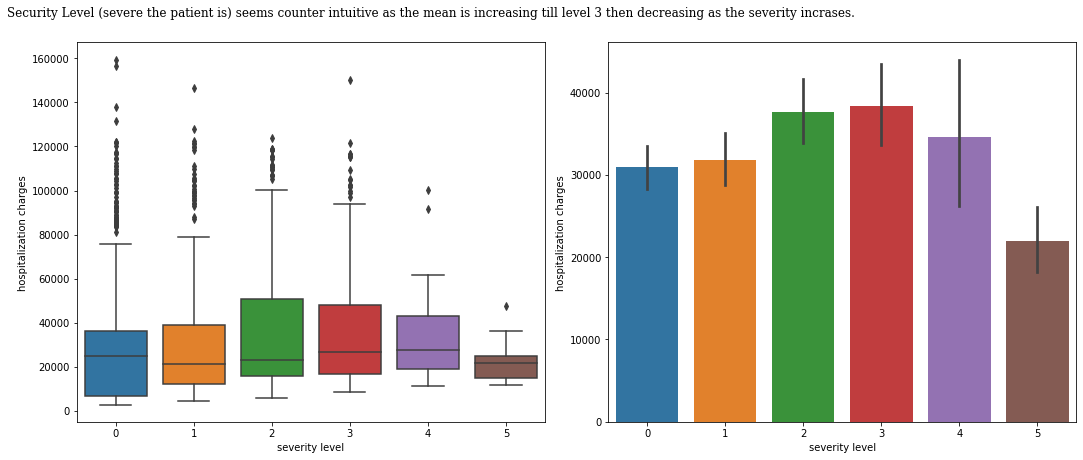

In [110]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

for i, col in enumerate(['hospitalization charges']):
    sns.boxplot(data=df, y=col, x='severity level', ax=ax[0])
    sns.barplot(data=df, y=col, x='severity level', ax=ax[1])


observation = '''Security Level (severe the patient is) seems counter intuitive as the mean is increasing till level 3 then decreasing as the severity incrases. 
'''
fig.text(0, 1, observation, fontsize=12, fontweight='light', fontfamily='serif')
plt.tight_layout()
plt.show()

**AGE_BIN $\;\;\;$ VS $\;\;\;$ HOSPITALIZATION CHARGES $\;$ & $\;$ VIRAL LOAD**

Observation:

As the age increases the hospitalization charges, viral load also gradually increases.

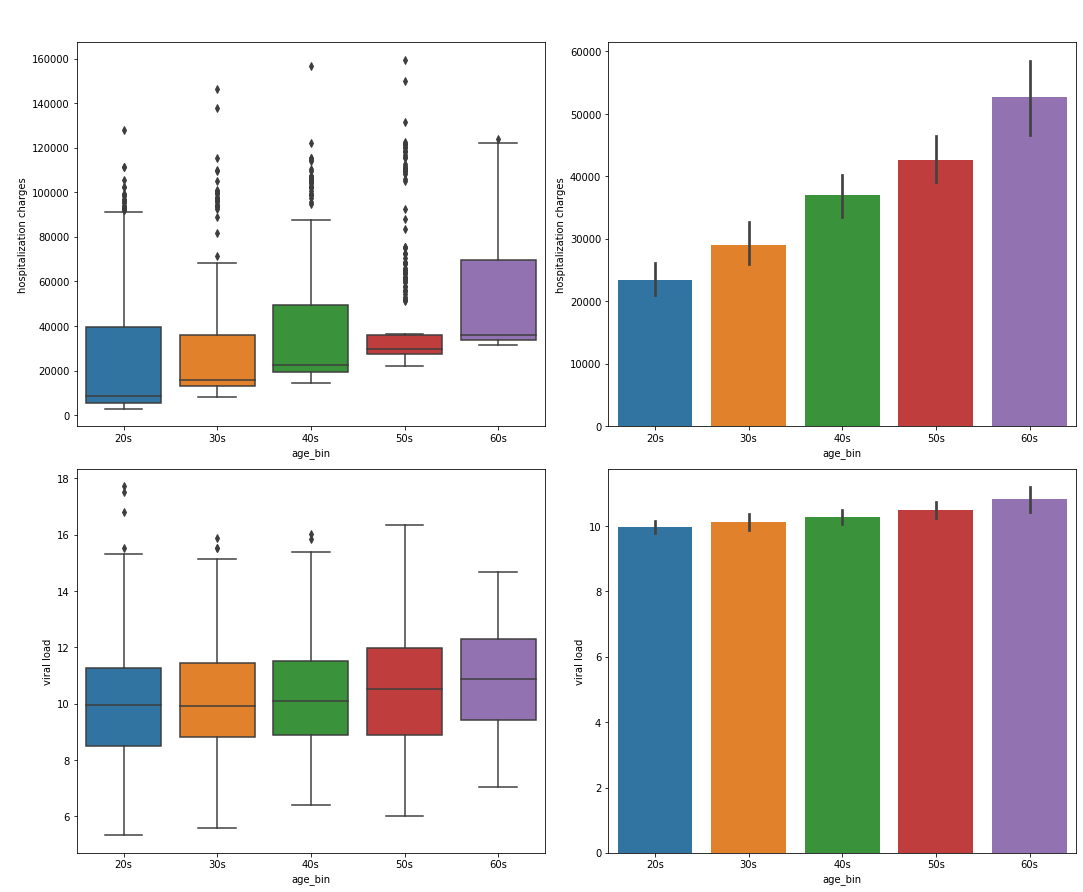

In [111]:
fig, ax = plt.subplots(2,2, figsize=(15,12))

for i, col in enumerate(['hospitalization charges', 'viral load']):
    sns.boxplot(data=df, y=col, x='age_bin', ax=ax[i][0])
    sns.barplot(data=df, y=col, x='age_bin', ax=ax[i][1])


observation = '''
'''
fig.text(0, 1, observation, fontsize=12, fontweight='light', fontfamily='serif')
plt.tight_layout()
plt.show()

### Categorical VS Categorical

**SMOKER $\;\;$ VS $\;\;$ COUNT $\;$ for different REGIONS**
<br>
<br>

Observation:

We can see that Sotheast region people smoke more than other regions, not just because it has more beneficiaries / records, we can also see % wise Southeast has more people than as compared to other regions. 

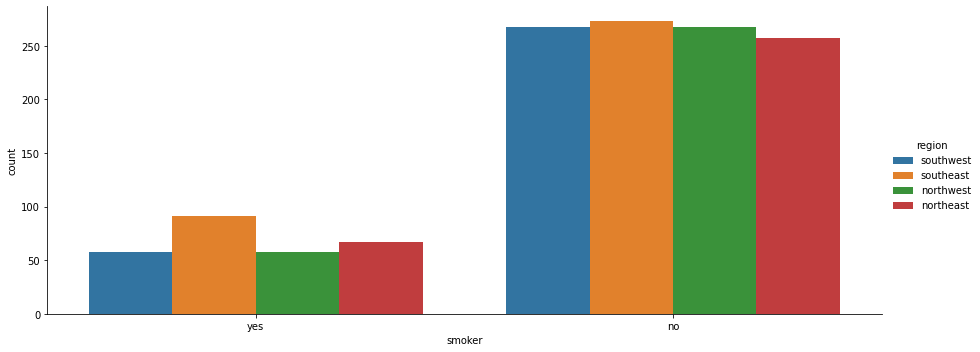

In [112]:
sns.catplot(data=df, x='smoker', hue='region', kind='count', height=5, aspect=2.5, legend=True)

**SEVERITY_LEVEL $\;\;$ VS $\;\;$ COUNT $\;$ for different AGE_BIN**
<br>
<br>

Observation:

We can see that severity level for young people are less.

As people gets older the severity level increases.

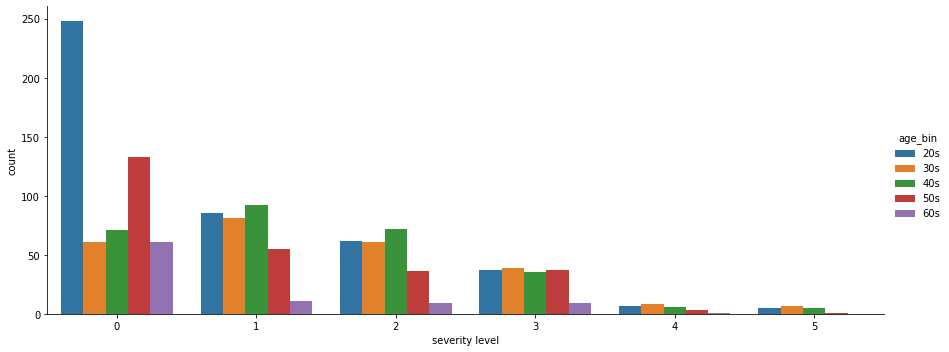

In [113]:
sns.catplot(data=df, x='severity level', hue='age_bin', kind='count', height=5, aspect=2.5, legend=True)

# Multivariate Analysis

Observation:

i>   We see that who ever has hospitalization charges more than around 8500 all are smokers, interesting.

ii>  It does not matter, if you are smoker or not you may have same amount of viral load (amount of virus in blood). 

iii> Also age does not matter to viral load (amount of virus in blood)

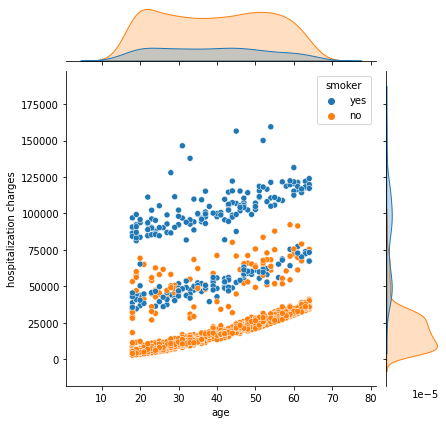

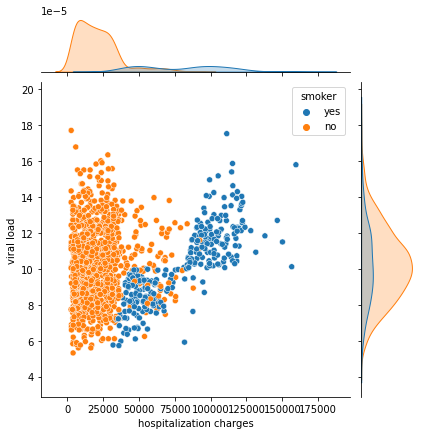

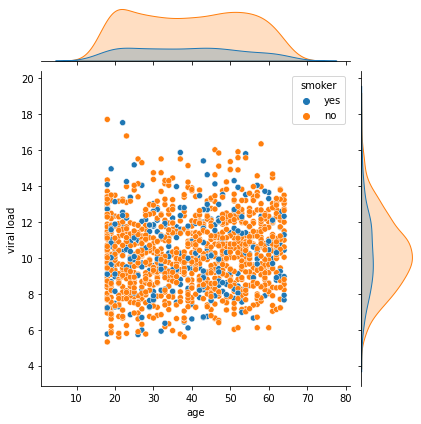

In [114]:
x_col, y_col = 'age', 'hospitalization charges'
sns.jointplot(data=df, x=x_col, y=y_col,  hue='smoker')
plt.show()
print('\n\n')

x_col, y_col = 'hospitalization charges', 'viral load'
sns.jointplot(data=df, x=x_col, y=y_col,  hue='smoker')
plt.show()
print('\n\n')


x_col, y_col = 'age', 'viral load'
sns.jointplot(data=df, x=x_col, y=y_col,  hue='smoker')
plt.show()
print('\n\n')

Observations:

For different regions and severity level, hospitalization charges varies like below:

SouthWest: 2 > 4 > 0 > 3 = 2 > 5

SouthEast: 3 > 2 > 4 > 0 > 1 > 5

NorthWest: 3 > 2 > 4 > 0 > 1 > 5

NorthEast: 1 > 4 > 3 > 2 > 1 > 5

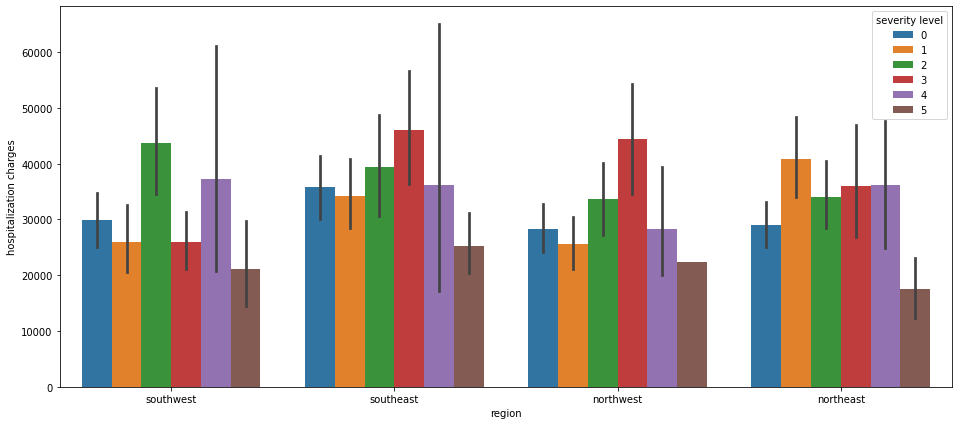

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16,7))
sns.barplot(data=df, x='region', y='hospitalization charges', hue='severity level')
plt.show()

Observations:

Except for NorthWest region other regions have significantly higher mean hospitalization charges for males than females.

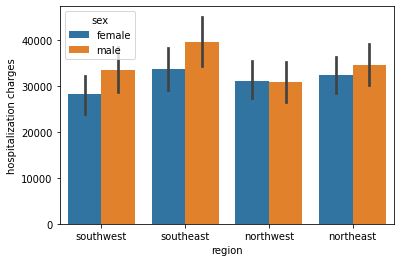

In [12]:
sns.barplot(data=df, x='region', y='hospitalization charges', hue='sex')

Observations:

Irrespective of region Smokers pay higher hospitalization bills than non smokers.

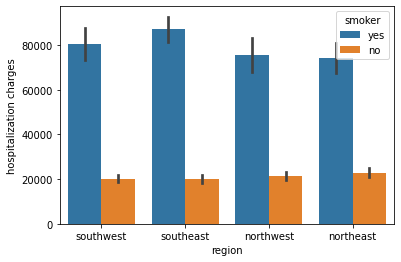

In [13]:
sns.barplot(data=df, x='region', y='hospitalization charges', hue='smoker')

Observations:

On an average as age increases hospitalization charges also increases.

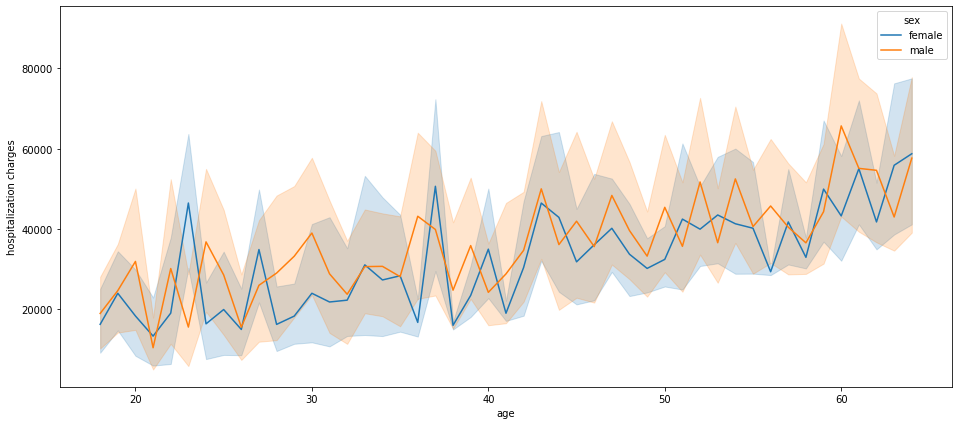

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
sns.lineplot(data=df, x='age', y='hospitalization charges', hue='sex')
plt.show()

Observations:

Viral load gets too high if the person is older than around 50 years and severity level is 5.  

These people can be the ones who can spread the virus a lot.

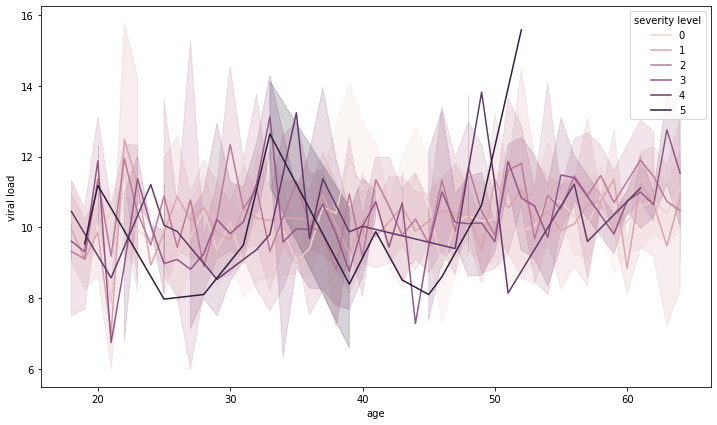

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
palette = sns.color_palette("flare")
palette = ['red', 'green', 'yellow', 'blue']
sns.lineplot(data=df, x='age', y='viral load', hue='severity level')
plt.show()

Correlation Plot
<br>
<br>
Observations:

Hospitalization charges and smokers are highly +ve correlated.

Hospitalization charges and age are +ve correlated.

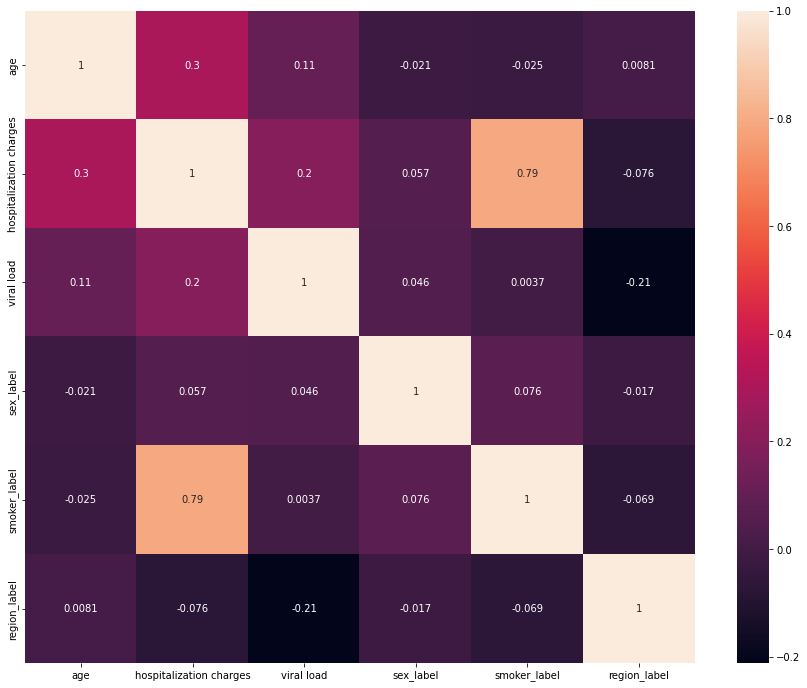

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(15,12))
sns.heatmap(df[numerical_cols].corr(), annot=True)

# Statistical Analysis

### **Prove (or disprove) that the hospitalization charges of people who do smoking are greater than those who don't?**

---
Assumptions:

1) Are the two samples independent? 
<br>
Yes one person smoking does not depend on another.
<br>
<br>
2) Are the data from each of the 2 groups following a normal distribution?
<br>
From the below Shapario Wilk's test, QQ plot, and CDF shows that data is NOT normally distributed.

Performing any transformations could hamper the true outcome of statistical analysis. So we will just remove outliers, will not do any transformation to our data.
<br>
<br>
3) Do the two samples have the same variances (Homogeneity of Variance)?
<br>
Levene test passes with a P-val of 0.57. So equal variance.

---
Null Hypothesis (H0): Mean of hospitalization charges for smoking people <= Mean of hospitalization charges for NON smoking people
<br>
Alternate Hypothesis (Ha): Mean of hospitalization charges for smoking people > Mean of hospitalization charges for NON smoking people
<br>

From the below we can see that we got a P-val of 6.526046543721583e-53.

It is very less than 0.05. So we can safely say that we need to reject null hypothesis and accept alternate hypothesis.
<br>
<br>

Conclusion:
<br>
With 95% confident we can say that mean of hospitalization charges for smokers > non smokers.

Difference in shapes between original df and after removing outliers:  139
Shapiro Wilk test for normality check for sample1, gives test_statistics and p_val of: ShapiroResult(statistic=0.918187141418457, pvalue=8.123142833937891e-07)
Shapiro Wilk test for normality check for sample2, gives test_statistics and p_val of: ShapiroResult(statistic=0.8823368549346924, pvalue=9.948521118019471e-09)
LeveneResult(statistic=0.30789815683641414, pvalue=0.5794535656923525)





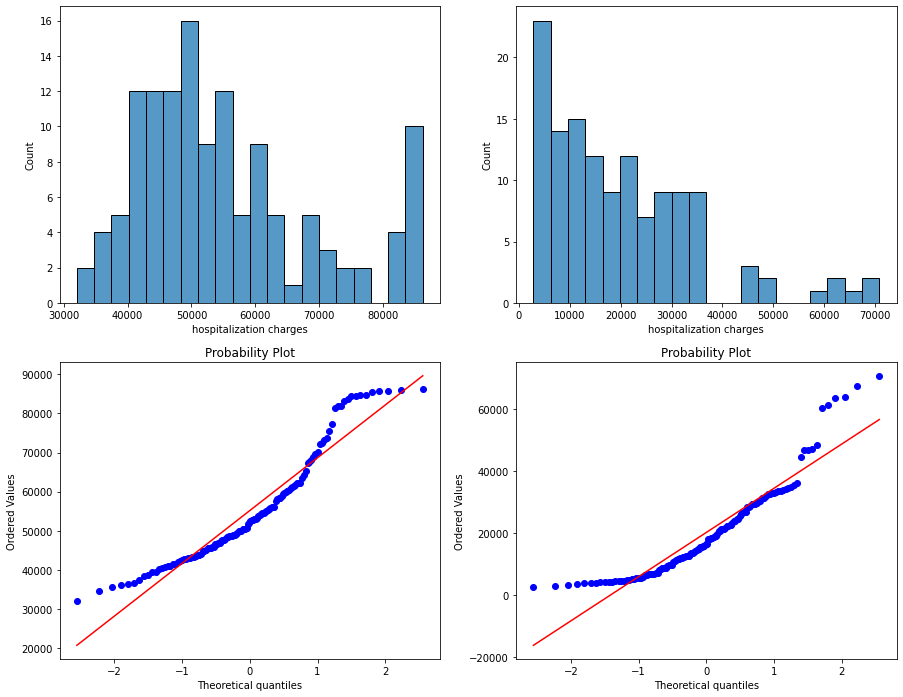

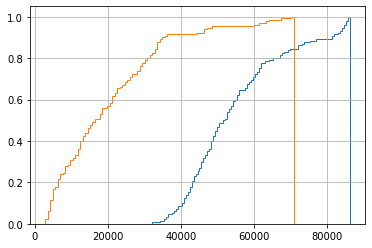

In [37]:
from scipy import stats


# Here we will remove points above  (Q3 + 1.5*IQR) as outliers
q75, q25 = np.percentile(df['hospitalization charges'], [75 ,25])
IQR = q75-q25
new_df = df[(df['hospitalization charges']<(q75+(1.5*IQR))) & (df['hospitalization charges']>(q25-(1.5*IQR)))]
print('Difference in shapes between original df and after removing outliers: ', df.shape[0] - new_df.shape[0])


random_state = 42

# Our sample1 is working day sample, sample2 is non workingday sample
sample1 = new_df[new_df['smoker']=='yes']['hospitalization charges'].sample(n=130, random_state=random_state)
sample2 = new_df[new_df['smoker']=='no']['hospitalization charges'].sample(n=130, random_state=random_state)

print(f"Shapiro Wilk test for normality check for sample1, gives test_statistics and p_val of: {stats.shapiro(sample1)}")
print(f"Shapiro Wilk test for normality check for sample2, gives test_statistics and p_val of: {stats.shapiro(sample2)}")
print(stats.levene(sample1, sample2))
print('\n\n')


fig, ax = plt.subplots(2, 2, figsize=(15,12))

sns.histplot(data=sample1, bins=20, ax=ax[0][0])
sns.histplot(data=sample2, bins=20, ax=ax[0][1])

prob = stats.probplot(sample1, dist=stats.norm, plot=ax[1][0])
prob = stats.probplot(sample2, dist=stats.norm, plot=ax[1][1])

plt.show()
print('\n\n')


plt.grid()
plt.hist(sample1, bins=100, cumulative=True, label='CDF', density=True, histtype='step')
plt.hist(sample2, bins=100, cumulative=True, label='CDF', density=True, histtype='step')
plt.show()

In [39]:
# here we need to perform equal variance test, reason mentioned in the assumption part
# also we need to perform 2 right tailed test

from scipy.stats import ttest_ind
ttest_ind(sample1, sample2, equal_var=True, alternative='greater')

Ttest_indResult(statistic=19.48441061661032, pvalue=6.526046543721583e-53)

---

KS Test:

In the above we did a Parametric test, where we assumed that samples are Gaussian distributed. In below we will perform the same check but with KS test which is non parametric just to get more confidence that because of not satisfying assumptions in T-test our hypothesis testing does not get affected too much.
<br>

Conclusion:

We can see that P-val is 1.  Clearly sample1 mean is greater than smaple2. Hence with 95% confident we can say that mean of hospitalization charges for smokers > non smokers.


In [40]:
stats.ks_2samp(sample1, sample2, alternative='greater')

KstestResult(statistic=0.0, pvalue=1.0)

### **Prove (or disprove) with statistical evidence that the viral load of females is different from that of males (T-test Two tailed)**

---
Assumptions:

1) Are the two samples independent? 
<br>
Yes male and females are independent of each other.
<br>
<br>
2) Are the data from each of the 2 groups following a normal distribution?
<br>
From the below Shapario Wilk's test, QQ plot, and CDF shows that data is normally distributed.
<br>
<br>
3) Do the two samples have the same variances (Homogeneity of Variance)?
<br>
Levene test statisfies with a p-val: 0.62.  So the samples have same variance. SO we will use  "2 sample independent T test with equal variance".

---
Null Hypothesis (H0): Mean of viral load for male = Mean of viral load for female
<br>
Alternate Hypothesis (Ha): Mean of viral load for male <> Mean of viral load for female
<br>

We can see P-val = 0.145 for T test, so we cant reject null hypothesis for 2 sample independent, equal variance and two sided T test. 

P-val = 0.134 for KS test, so again the samples means are same.
<br>
<br>

Conclusion:
<br>
So with 95% confident we can say that mean of viral load for males and females are same.

Difference in shapes between original df and after removing outliers:  9
Shapiro Wilk test for normality check for sample1, gives test_statistics and p_val of: ShapiroResult(statistic=0.9950356483459473, pvalue=0.5964782238006592)
Shapiro Wilk test for normality check for sample2, gives test_statistics and p_val of: ShapiroResult(statistic=0.9922558069229126, pvalue=0.21466858685016632)
LeveneResult(statistic=0.24309201888929988, pvalue=0.6221990903752384)





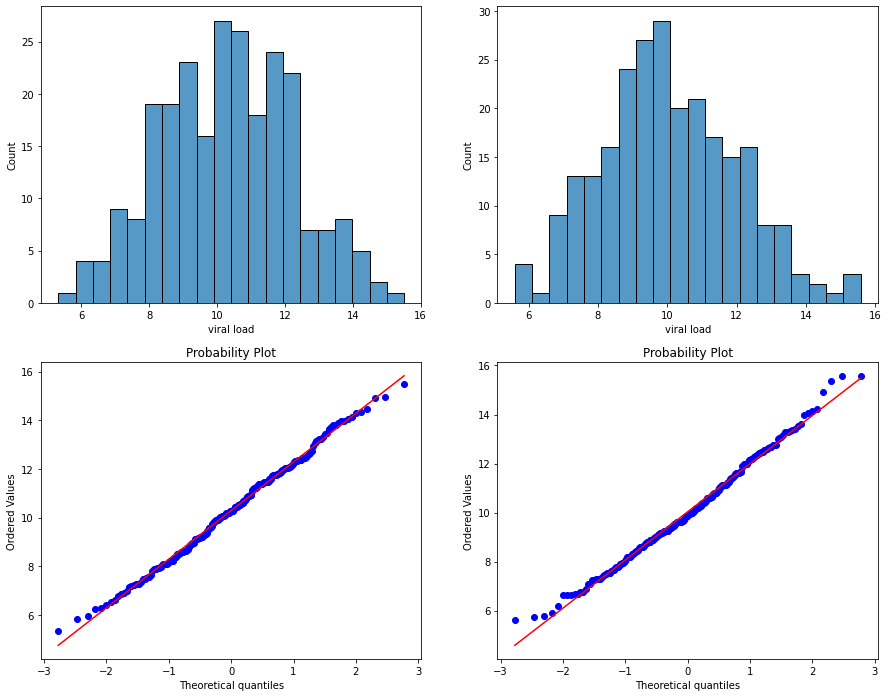

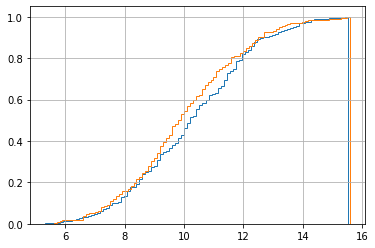

In [51]:
# Here we will remove points above  (Q3 + 1.5*IQR) as outliers
q75, q25 = np.percentile(df['viral load'], [75 ,25])
new_df = df[df['viral load']<(q75+(1.5*(q75-q25)))]
print('Difference in shapes between original df and after removing outliers: ', df.shape[0] - new_df.shape[0])


random_state = 42

# Our sample1 is working day sample, sample2 is non workingday sample
sample1 = new_df[new_df['sex']=='male']['viral load'].sample(n=250, random_state=random_state)
sample2 = new_df[new_df['sex']=='female']['viral load'].sample(n=250, random_state=random_state)

print(f"Shapiro Wilk test for normality check for sample1, gives test_statistics and p_val of: {stats.shapiro(sample1)}")
print(f"Shapiro Wilk test for normality check for sample2, gives test_statistics and p_val of: {stats.shapiro(sample2)}")
print(stats.levene(sample1, sample2))
print('\n\n')


fig, ax = plt.subplots(2, 2, figsize=(15,12))

sns.histplot(data=sample1, bins=20, ax=ax[0][0])
sns.histplot(data=sample2, bins=20, ax=ax[0][1])

prob = stats.probplot(sample1, dist=stats.norm, plot=ax[1][0])
prob = stats.probplot(sample2, dist=stats.norm, plot=ax[1][1])

plt.show()
print('\n\n')


plt.grid()
plt.hist(sample1, bins=100, cumulative=True, label='CDF', density=True, histtype='step')
plt.hist(sample2, bins=100, cumulative=True, label='CDF', density=True, histtype='step')
plt.show()

In [52]:
from scipy.stats import ttest_ind

# here we need to perform equal variance test, reason mentioned in the assumption part
# also we need to perform 2 sided test

print("results of T test:   " , ttest_ind(sample1, sample2, equal_var=True, alternative='two-sided'))
print("results of KS test:   " ,stats.ks_2samp(sample1, sample2, alternative='two-sided'))

results of T test:    Ttest_indResult(statistic=1.4594210829241205, pvalue=0.14507972227082486)
results of KS test:    KstestResult(statistic=0.104, pvalue=0.13390812077849387)


### **Is the proportion of smoking significantly different across different regions? (Chi-square)**

Chi-Square is Non-Parametric test. So we dont have to check for any sample distributions.
<br>
<br>

Null hypothesis (H0): Smoking does not depend on region.

Alternate hypothesis(Ha): Smoking depends on region.
<br>
<br>


Conslusion:

We can see P_val is 0.5.  So we can not reject null hypothesis. So that means smoking does not depend on the region.


In [122]:
# this is what our data observed looks like 
obs_df = pd.crosstab(index=df['region'], columns=df['smoker'], margins=True)
display(obs_df)

smoker,no,yes,All
region,,,
northeast,257,67,324
northwest,267,58,325
southeast,273,91,364
southwest,267,58,325
All,1064,274,1338


In [123]:
# now we wil perform chi square test
test_stat, p_val, deg_freedom, exp_data = stats.chi2_contingency(obs_df)
print('Observation from chi square test:')
print('Test statistics: ', test_stat)
print('P_Val: ', p_val)
print('degrees of freedom: ', deg_freedom)
print('\nExpected data:')
display(pd.DataFrame(exp_data, columns=['no', 'yes', 'All'], index=['northeast', 'northwest', 'southeast', 'southwest', 'All']))

Observation from chi square test:
Test statistics:  7.34347776140707
P_Val:  0.5000675325877666
degrees of freedom:  8

Expected data:


,no,yes,All
northeast,257.650224,66.349776,324.0
northwest,258.445441,66.554559,325.0
southeast,289.458894,74.541106,364.0
southwest,258.445441,66.554559,325.0
All,1064.000000,274.000000,1338.0


### **Is the mean viral load of women with 0 Severity level , 1 Severity level, and 2 Severity level the same? (One way Anova)**

---

Assumptions:
1. Each group sample is drawn from a normally distributed population: 
<br>
We will check if the feature "count" is normally disributed using Shapiro Wilk test, after removing outliers ofcourse.
<br>
We see that Shapiro Wilk test is failing(with P-val=0.009). However histogram and QQ plot shows that data is nearly normal distributed. Also when the sample size is very large sometimes non Gaussian Disributed data also works well.
<br>
Also here we can not transofrm the "viral load" variable to log or box-cox to get normal distribution, because tansforming will change the variance of the dataset, hence the Anova results will not be accurate.
<br>
<br>
2. All populations have a common variance: 
<br>
Levene test of equal variance gives us P-val = 0.18.  So with 95% confidence we can say that samples has common variance.
<br>
<br>
3. All samples are drawn independently of each other: 
<br>
This we are sure of that each sample is drawn randomly from others.
<br>

---
Null hypothesis(H0): mu1 = mu2 = mu3 (Means of all the samples of viral load for different severity level types are same.)
<br>
Alternate hypothesis(Ha): At least one sample is not the same.
<br>
<br>

Conclusion:
<br>
We found that P-val of Anova test is 0.85. Which states that the means are same. Hence we can say that viral load does not depend on severity level.

Size of females 662
Difference in records between original df and after removing outliers:  5
Shapiro Wilk test for normality check for count variable, gives test_statistics and p_val of: ShapiroResult(statistic=0.9939059615135193, pvalue=0.009464985691010952)





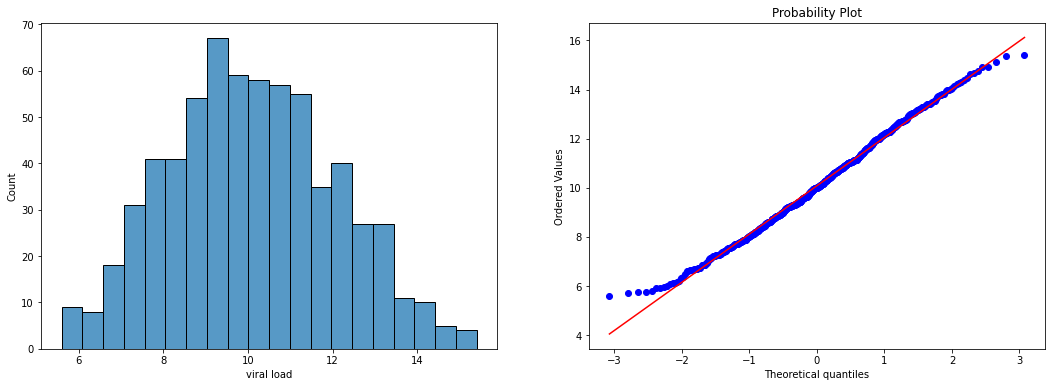




Variance check between sample1 and sample2 and sample3 LeveneResult(statistic=1.682431294185746, pvalue=0.18768840403022202)


In [124]:
# As we are testing for womens only so we need to filter out women records only
women_df = df[df['sex']=='female']
print(f"Size of females {women_df.shape[0]}")

# Here we will remove points above  (Q3 + 1.5*IQR) as outliers
q75, q25 = np.percentile(women_df['viral load'], [75 ,25])
new_df = women_df[women_df['viral load']<(q75+(1.5*(q75-q25)))]
print('Difference in records between original df and after removing outliers: ', women_df.shape[0] - new_df.shape[0])
print(f"Shapiro Wilk test for normality check for count variable, gives test_statistics and p_val of: {stats.shapiro(new_df['viral load'])}")
print('\n\n')


# Normality check of the population 
fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.histplot(data=new_df['viral load'], bins=20, ax=ax[0])
prob = stats.probplot(new_df['viral load'], dist=stats.norm, plot=ax[1])
plt.show()
print('\n\n')


# Variance check of the samples,

# we will create 3 samples, In each sample we will take 200 random data points
# sample1: samples of viral load for severity_level_0
# sample2: samples of viral load for severity_level_1
# sample3: samples of viral load for severity_level_2

# random state to generate same random samples every time we run the code 
random_state = 42

sample1 = new_df[new_df['severity level']==0]['viral load'].sample(n=100, random_state=random_state)
sample2 = new_df[new_df['severity level']==1]['viral load'].sample(n=100, random_state=random_state)
sample3 = new_df[new_df['severity level']==2]['viral load'].sample(n=100, random_state=random_state)

print(f"Variance check between sample1 and sample2 and sample3 {stats.levene(sample1, sample2, sample3)}")

In [125]:
# Now we will start with our ANOVA test 
from scipy.stats import f_oneway

# We will use one way Anova as we have only one dependent variable
f_oneway(sample1, sample2, sample3)

F_onewayResult(statistic=0.16082244960842035, pvalue=0.851517328331995)

CLT:

---

Above we assumed that the distribution for "viral load" is Normal by seeing QQ plot, but the normality tests like ShapiroWilk's test failed.

So to be more confident we will also perform CLT which satisfies all the conditions like finite mean and variance. 


Conclusion:
<br>
Here also we see that the 95% confident intervals are overlapping. So we can say that viral load does not depend on severity level.

Size of females 662
Difference in records between original df and after removing outliers:  5


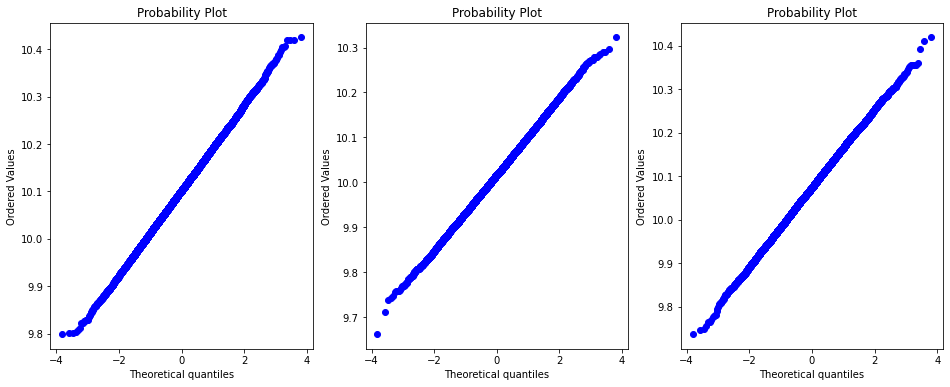

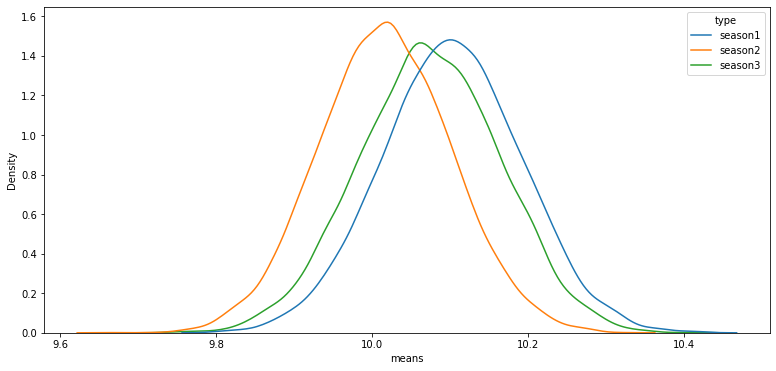

In [126]:
# As we are testing for womens only so we need to filter out women records only
women_df = df[df['sex']=='female']
print(f"Size of females {women_df.shape[0]}")


# Here we will remove points above  (Q3 + 1.5*IQR) as outliers
q75, q25 = np.percentile(women_df['viral load'], [75 ,25])
new_df = women_df[women_df['viral load']<(q75+(1.5*(q75-q25)))]
print('Difference in records between original df and after removing outliers: ', women_df.shape[0] - new_df.shape[0])


# we will create 3 samples, In each sample we will take 200 random data points
# sample1: samples of bike rent count for weather1 
# sample2: samples of bike rent count for weather2
# sample3: samples of bike rent count for weather3

# random state to generate same random samples every time we run the code 
random_state = 42

sample1 = new_df[new_df['severity level']==0]['viral load']
sample2 = new_df[new_df['severity level']==1]['viral load']
sample3 = new_df[new_df['severity level']==2]['viral load']

# print(sample1.shape, sample2.shape, sample3.shape)


# Now we will take the sampels for CLT
sample1_means = []
sample2_means = []
sample3_means = []


# we will compute 10000 means
r = 10000

# each time we will sample 100000 samples
for i in range(r):
    sample1_means.append(np.mean(np.random.choice(sample1, size=500, replace=True)))

for i in range(r):
    sample2_means.append(np.mean(np.random.choice(sample2, size=500, replace=True)))

for i in range(r):
    sample3_means.append(np.mean(np.random.choice(sample3, size=500, replace=True)))


#QQ-Plot to check if our sample size is enough to get a gaussian distribution of means 
fig, ax = plt.subplots(1,3, figsize=(16,6))
prob = stats.probplot(sample1_means, dist=stats.norm,  fit=False, plot=ax[0])
prob = stats.probplot(sample2_means, dist=stats.norm,  fit=False, plot=ax[1])
prob = stats.probplot(sample3_means, dist=stats.norm,  fit=False, plot=ax[2])
plt.show()
print('\n\n')



fig, ax = plt.subplots(1,1, figsize=(13,6))
data = pd.concat( (pd.DataFrame({'means': sample1_means, 'type':'season1'}),
                   pd.DataFrame({'means': sample2_means, 'type':'season2'}),
                   pd.DataFrame({'means': sample3_means, 'type':'season3'})) ).reset_index()
sns.kdeplot(data=data, x='means', hue='type')
plt.show()

# Insights

from univariate analysis:
1. We have more beneficiaries in the young age i.e. 18 and 19
2. Male and female contributions are almost same.
3. Only around 20% of people are smokers and rest are non smokers.
4. Almost 33% beneficiaries are among the range 18-30.
5. More people are less severe, count of beneficiaries decreases as  severity level increases.

from bivariate analysis:
6. Medical cost billed to health insurance are way higher for smokers than non smokers. As it should be.
7. As the age increases the viral load and hospitalization charges both increases gradullay.

from multivariate analysis:
9. Interestingly, We see that who ever has hospitalization charges more than around 8500 all are smokers.
10. Viral load does not depend on smoker / non smoker, young / old.

from statistical analysis:
11. With 95% confidence we can say that mean of hospitalization charges for smokers > non smokers.
12. With 95% confidence we can say that mean of viral load for males and females are same.
13. With 95% confidence smoking does not depend on the region.
14. With 95% confidence we can say that viral load does not depend on severity level for womens.

# Actions On Business

1. We should focus more on getting more older people joining our insurance policy as beneficiaries.
2. Smokers tend to buy more costly insurance, hence high hospitalization charges. We can try advertising the same thorugh differnt mediums to help people quit smoking.
3. Aged and smoked people are high chances of getting hospitalized, hence we can spread awareness for these people to stay healthy to avoid being hospitalized.
4. Hospitals business can grow much faster if we try to get more people who smokes and offer them some sort of discount on their hospitalization charges.
5. Viral load is higher for old patients so we need strict precautions to separate them from other patients.